# Place Connectivity Index and Covid-19

In [6]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# For t-tests
from scipy import stats
from scipy.stats import shapiro, levene

# For GWR
import mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from shapely.geometry import Point

## Read data
### 2018 Census county boundaries

- Downloaded from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [7]:
bounds = gpd.read_file(
    'datasets_extra/cb_2018_us_county_20m.zip'
).filter([
    'GEOID', 'NAME', 'geometry'
]).to_crs(5069)

bounds.columns = ['fips', 'name', 'geometry']

bounds

,fips,name,geometry
0,37017,Bladen,"POLYGON ((1542640.494 1447456.572, 1551464.607..."
1,37167,Stanly,"POLYGON ((1393382.329 1463255.263, 1405830.781..."
2,39153,Summit,"POLYGON ((1187557.798 2103745.093, 1185353.766..."
3,42113,Sullivan,"POLYGON ((1576895.437 2224696.674, 1626112.918..."
4,48459,Upshur,"POLYGON ((79044.449 1065759.283, 78862.626 109..."
...,...,...,...
3215,38005,Benson,"POLYGON ((-287677.211 2824832.901, -261237.102..."
3216,72079,Lajas,"POLYGON ((3131452.322 -52317.810, 3135445.309 ..."
3217,31159,Seward,"POLYGON ((-114056.575 2005004.849, -75936.995 ..."
3218,37023,Burke,"POLYGON ((1256426.882 1518949.369, 1251928.253..."


### County-level place connectivity index - PCI (2019)

In [8]:
pci = (
    pd.read_csv(
        'datasets_li/US_County_PCI_2019.csv',
        dtype={'place_i': 'str'}
    )
    .groupby('place_i')
    [['pci']].sum()
    .reset_index()
    .rename(columns={'place_i': 'fips'})
    .assign(
        pci_cat=lambda df_: pd.qcut(
            df_.pci,
            [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            labels=['very low', 'low', 'medium', 'high', 'very high']
        )
    )
    .filter(['pci_cat', 'pci', 'fips'])
)

pci

,pci_cat,pci,fips
0,very high,8078.268,01001
1,very high,10194.793,01003
2,medium,4902.281,01005
3,medium,4687.708,01007
4,very low,3146.959,01009
...,...,...,...
3102,very high,12562.222,56037
3103,very high,10525.378,56039
3104,very high,10532.539,56041
3105,low,4377.208,56043


In [9]:
pci['pci_cat'].value_counts()

pci_cat
very low     622
very high    622
low          621
medium       621
high         621
Name: count, dtype: int64

In [10]:
assert pci['pci'].isna().sum() == 0, "Some PCI values are 0! Fix!"

### Median Age

In [11]:
age = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B01002-Data.csv',
        skiprows=1
    )
    .filter(['Geography', 'Estimate!!Median age --!!Total:'])
    .assign(Geography=lambda df_: df_.Geography.str.split('US').str[-1])
)

age.columns = ['fips', 'age']

age

,fips,age
0,01001,38.2
1,01003,43.0
2,01005,40.4
3,01007,40.9
4,01009,40.7
...,...,...
3215,72145,41.5
3216,72147,47.0
3217,72149,40.1
3218,72151,42.9


In [12]:
hh_income = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B19013-Data.csv',
        skiprows=1
    )
    .filter(['Geography', 'Estimate!!Median household income in the past 12 months (in 2019 inflation-adjusted dollars)'])
    .assign(Geography=lambda df_: df_.Geography.str.split('US').str[-1])
)

hh_income.columns = ['fips', 'hh_income']

hh_income

,fips,hh_income
0,01001,58731
1,01003,58320
2,01005,32525
3,01007,47542
4,01009,49358
...,...,...
3215,72145,19617
3216,72147,14936
3217,72149,19877
3218,72151,16295


In [13]:
bachelors = (
    pd.read_csv(
        'datasets_extra/ACSST5Y2019.S1501-Data.csv',
        skiprows=1
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
        bachelors=lambda df_: \
            df_["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"] \
            / df_["Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over"] \
            * 100
    )
    .filter(['Geography', 'bachelors'])
)

bachelors.columns = ['fips', 'bachelors']

bachelors

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/1992937972.py:2: DtypeWarning: Columns (122,123,124,125,192,193,194,195,228,229,230,231,234,235,236,237,244,245,378,379,380,381,388,389,390,391,392,393,394,395,436,437,438,439,448,449,450,451,490,491,492,493,500,501,630,631,644,645,646,647,648,649,650,651,680,681,682,683,704,705,706,707,746,747,748,749,750,751,756,757) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,fips,bachelors
0,01001,26.571574
1,01003,31.862460
2,01005,11.578713
3,01007,10.378525
4,01009,13.093413
...,...,...
3215,72145,21.222300
3216,72147,17.999358
3217,72149,19.912819
3218,72151,18.003019


In [14]:
insured = (
    pd.read_csv(
        'datasets_extra/ACSST5Y2019.S2701-Data.csv',
        skiprows=1
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
        insured=lambda df_: \
            df_["Estimate!!Insured!!Civilian noninstitutionalized population"] \
            / df_["Estimate!!Total!!Civilian noninstitutionalized population"] \
            * 100
    )
    .filter(['Geography', 'insured'])
)

insured.columns = ['fips', 'insured']

insured

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/3027006613.py:2: DtypeWarning: Columns (250,251,258,259,290,291,298,299,300,301,302,303,308,309,326,327,334,335,356,357,494,495,502,503,534,535,542,543,544,545,546,547,552,553,570,571,578,579,600,601) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


,fips,insured
0,01001,92.931515
1,01003,91.118138
2,01005,88.680756
3,01007,89.332105
4,01009,89.235717
...,...,...
3215,72145,90.490845
3216,72147,87.965749
3217,72149,96.246240
3218,72151,94.963384


## Covid-19 for the year 2020 (NYTimes)
- The dates are reported cumulatively (so previous total for each date)
- We want to get monthly dates, so extact only the final day of each month from March onwards
- We also want get new monthly cases/deaths, not cumulative- subtract previous month

In [15]:
covid20_ = (
    pd.read_csv(
        'datasets_extra/nytimes-covid/us-counties-2020.csv',
        dtype={'fips': str}
    )
    .dropna(subset=['fips'])
    .assign(
        month=lambda df_: df_.date.str[:-3]
    )
    .sort_values(['fips', 'month'])
    .groupby(['fips', 'month'])
    [['cases', 'deaths']]
    .max()
    .sort_index()
)

covid20_.fillna(0, inplace=True)

In [16]:
covid20_

cases  deaths
fips  month                 
01001 2020-03      7     0.0
      2020-04     43     4.0
      2020-05    221     4.0
      2020-06    537    12.0
      2020-07   1015    21.0
...              ...     ...
78030 2020-08    680    10.0
      2020-09    764    13.0
      2020-10    796    14.0
      2020-11    869    15.0
      2020-12   1028    15.0

[30396 rows x 2 columns]

In [17]:
covid20 = (
    covid20_
    .groupby(level=0)
    .diff()
    .fillna(covid20_)
    .reset_index()
    .fillna(0)
)

In [18]:
covid20

,fips,month,cases,deaths
0,01001,2020-03,7.0,0.0
1,01001,2020-04,36.0,4.0
2,01001,2020-05,178.0,0.0
3,01001,2020-06,316.0,8.0
4,01001,2020-07,478.0,9.0
...,...,...,...,...
30391,78030,2020-08,546.0,6.0
30392,78030,2020-09,84.0,3.0
30393,78030,2020-10,32.0,1.0
30394,78030,2020-11,73.0,1.0


### The months' cases and deaths

In [19]:
# Calculate 'dc' (death per case) while handling division by zero
# There are 5 samples where cases = 0 but deaths = 1, ignore those
covid20['dc'] = (
    covid20.apply(
        lambda x: 0 if x['cases'] == 0 else x['deaths'] / x['cases'],
        axis=1
    )
)

In [20]:
assert covid20.dc.isna().sum() == 0, \
    "Whoops! Ratios should not be null!"

In [21]:
# Pivot cases by month
cases_months = (
    covid20
    .pivot(index='fips', columns='month', values='cases')
    .fillna(0)
)
cases_months.columns = [ f'cases_{x[5:]}' for x in cases_months.columns ]
cases_months.reset_index(inplace=True)

# Pivot deaths by month
deaths_months = (
    covid20
    .pivot(index='fips', columns='month', values='deaths')
    .fillna(0)
)
deaths_months.columns = [ f'deaths_{x[5:]}' for x in deaths_months.columns ]
deaths_months.reset_index(inplace=True)

# Pivot death ratios by month
dc = (
    covid20
    .pivot(index='fips', columns='month', values='dc')
    .fillna(0)
)
dc.columns = [ f'dc_{x[5:]}' for x in dc.columns ]
dc.reset_index(inplace=True)

In [22]:
cases_months

,fips,cases_01,cases_02,cases_03,cases_04,cases_05,cases_06,cases_07,cases_08,cases_09,cases_10,cases_11,cases_12
0,01001,0.0,0.0,7.0,36.0,178.0,316.0,478.0,427.0,349.0,368.0,621.0,1410.0
1,01003,0.0,0.0,19.0,155.0,116.0,390.0,2421.0,1444.0,1095.0,1300.0,1950.0,4711.0
2,01005,0.0,0.0,0.0,39.0,128.0,158.0,273.0,159.0,139.0,164.0,118.0,336.0
3,01007,0.0,0.0,3.0,39.0,33.0,95.0,193.0,191.0,110.0,209.0,323.0,638.0
4,01009,0.0,0.0,5.0,32.0,25.0,146.0,559.0,520.0,342.0,445.0,923.0,1644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3213,72151,0.0,0.0,0.0,0.0,12.0,24.0,56.0,111.0,120.0,164.0,98.0,155.0
3214,72153,0.0,0.0,0.0,0.0,53.0,37.0,104.0,122.0,99.0,172.0,149.0,142.0
3215,78010,0.0,0.0,0.0,27.0,3.0,15.0,211.0,166.0,73.0,17.0,78.0,239.0
3216,78020,0.0,0.0,0.0,2.0,0.0,2.0,12.0,21.0,23.0,8.0,17.0,89.0


### Hospitals
- Get counts by county (fips)
- Source: https://www.kaggle.com/datasets/andrewmvd/us-hospital-locations

In [23]:
# Let's estimate nuumber of beds for the hospitals where we don't have the data
# We'll use the median number of hospitals in the datasets (excluding -999)
pd.read_csv(
    'datasets_extra/us_hospital_locations.csv'
).query('BEDS > 0').BEDS.median()

77.0

In [24]:
hospital_beds = (
    pd.read_csv(
        'datasets_extra/us_hospital_locations.csv'
    )
    .replace(-999, 77)
    .groupby('COUNTYFIPS')
    .BEDS.sum()
    .reset_index()
    .rename(columns={
        'BEDS': 'hospital_beds',
        'COUNTYFIPS': 'fips'
    })
)

hospital_beds

,fips,hospital_beds
0,01001,85
1,01003,398
2,01005,74
3,01007,35
4,01009,40
...,...,...
2572,72141,7
2573,72145,150
2574,72147,77
2575,72153,105


### Population counts

In [25]:
pop19 = (
    pd.read_csv(
        'datasets_extra/ACSDT5Y2019.B01001-Data.csv',
        skiprows=1,
        usecols=[0, 2]
    )
    .assign(
        Geography=lambda df_: df_.Geography.str.split('US').str[-1],
    )
    .dropna()
)

pop19.columns = ['fips', 'pop19']

pop19

,fips,pop19
0,01001,55380
1,01003,212830
2,01005,25361
3,01007,22493
4,01009,57681
...,...,...
3215,72145,52192
3216,72147,8642
3217,72149,22403
3218,72151,33499


### Combine

- Some counties have missing PCI and hence pci_cat
- We tried interpolating the values by looking at the neighbours, but neighbours in most cases would also have None values making the task difficult
- So we decided to drop counties where pci_cat is none

In [26]:
combined = (
    bounds
    .merge(pop19, on='fips', how='left')
    .merge(age, on='fips', how='left')
    .merge(hh_income, on='fips', how='left')
    .merge(insured, on='fips', how='left')
    .merge(bachelors, on='fips', how='left')
    .merge(pci, on='fips', how='left')
    .merge(hospital_beds, on='fips', how='left')
    .merge(cases_months, on='fips', how='left')
    .merge(deaths_months, on='fips', how='left')
    .merge(dc, on='fips', how='left')
).assign(
    cases_year=lambda df_: (
        df_.cases_03 + df_.cases_04 + df_.cases_05 + df_.cases_06
        + df_.cases_07 + df_.cases_08 + df_.cases_09 + df_.cases_10
        + df_.cases_11 + df_.cases_12
    ),
    deaths_year=lambda df_: (
        df_.deaths_03 + df_.deaths_04 + df_.deaths_05 + df_.deaths_06
        + df_.deaths_07 + df_.deaths_08 + df_.deaths_09 + df_.deaths_10
        + df_.deaths_11 + df_.deaths_12
    )
).assign(
    year_dc=lambda df_: df_.deaths_year / df_.cases_year,
    year_dp=lambda df_: df_.deaths_year / df_.pop19,
    year_cp=lambda df_: df_.cases_year / df_.pop19
).dropna(subset=['pci'])

combined

,fips,name,geometry,pop19,age,hh_income,insured,bachelors,pci_cat,pci,...,dc_08,dc_09,dc_10,dc_11,dc_12,cases_year,deaths_year,year_dc,year_dp,year_cp
0,37017,Bladen,"POLYGON ((1542640.494 1447456.572, 1551464.607...",33407,44.5,36173,87.085183,15.814943,very low,2748.868,...,0.019608,0.023923,0.022989,0.000000,0.010000,1843.0,24.0,0.013022,0.000718,0.055168
1,37167,Stanly,"POLYGON ((1393382.329 1463255.263, 1405830.781...",61588,42.2,52623,88.824477,17.322360,low,4182.453,...,0.032051,0.047710,0.038549,0.009311,0.000000,4331.0,78.0,0.018010,0.001266,0.070322
2,39153,Summit,"POLYGON ((1187557.798 2103745.093, 1185353.766...",541334,41.0,57181,94.316829,32.457614,very high,9805.822,...,0.015588,0.017764,0.009135,0.009736,0.019013,28040.0,589.0,0.021006,0.001088,0.051798
3,42113,Sullivan,"POLYGON ((1576895.437 2224696.674, 1626112.918...",6135,53.7,47407,92.336134,17.198618,very low,2087.819,...,0.000000,0.000000,0.142857,0.000000,0.024390,146.0,3.0,0.020548,0.000489,0.023798
4,48459,Upshur,"POLYGON ((79044.449 1065759.283, 78862.626 109...",41018,41.4,52162,83.278154,17.091444,low,3686.578,...,0.028777,0.060606,0.041667,0.074468,0.007276,1844.0,31.0,0.016811,0.000756,0.044956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,22003,Allen,"POLYGON ((274566.622 839855.528, 289018.162 84...",25618,38.2,46446,91.458372,11.288069,medium,4507.291,...,0.048662,0.073826,0.050980,0.019380,0.008596,2458.0,71.0,0.028885,0.002771,0.095948
3215,38005,Benson,"POLYGON ((-287677.211 2824832.901, -261237.102...",6873,30.5,47667,88.984409,16.155419,very low,2817.916,...,0.020979,0.017241,0.019802,0.017241,0.009479,990.0,16.0,0.016162,0.002328,0.144042
3217,31159,Seward,"POLYGON ((-114056.575 2005004.849, -75936.995 ...",17171,38.0,70389,94.908230,28.888480,medium,4656.636,...,0.014286,0.013333,0.000000,0.007310,0.043321,1571.0,20.0,0.012731,0.001165,0.091491
3218,37023,Burke,"POLYGON ((1256426.882 1518949.369, 1251928.253...",89968,44.1,44557,87.930877,16.438209,high,7264.207,...,0.015974,0.041096,0.016181,0.009756,0.004989,6195.0,75.0,0.012107,0.000834,0.068858


In [101]:
combined.groupby('pci_cat')[['age', 'hh_income', 'insured', 'bachelors']].mean().round(1)

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/2971879323.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby('pci_cat')[['age', 'hh_income', 'insured', 'bachelors']].mean().round(1)


,age,hh_income,insured,bachelors
pci_cat,,,,
very low,43.7,48189.7,89.6,17.1
low,42.7,49544.4,90.2,18.8
medium,41.6,52535.8,90.7,21.5
high,40.4,56166.7,91.0,23.7
very high,38.9,60144.8,90.8,28.7


### Let's count hospital density by PCI level

In [98]:
(combined.groupby('pci_cat').hospital_beds.sum() \
     / combined.groupby('pci_cat').pop19.sum() \
     * 100000
).round()

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/1172797274.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (combined.groupby('pci_cat').hospital_beds.sum() \
/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/1172797274.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / combined.groupby('pci_cat').pop19.sum() \


pci_cat
very low     207.0
low          262.0
medium       274.0
high         282.0
very high    362.0
dtype: float64

## Let's map PCI for all counties!

In [108]:
def plot_choropleth(column, cmap, title, source):
    
    (combined
     .plot(
         column=column,
         cmap=cmap,
         legend=True,
         figsize=(10, 5),
         #legend_kwds={'bbox_to_anchor':(0.13, 0.0), 'loc': 'lower right'}, # use for PCI grouped
         legend_kwds={'shrink': 0.4} # use for PCI
     )
    )

    plt.axis('off')
    #plt.title(title)

    """
    plt.annotate(
        source,
        xy=(250,20),
        xycoords='figure points',
        fontsize=9,
        color='gray',
        ha='center'
    )
    """

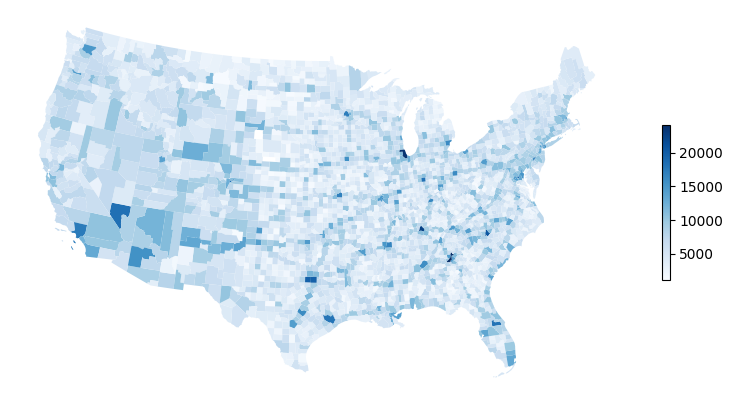

In [103]:
plot_choropleth(
    'pci',
    'Blues',
    'Aggregated Place Connectivity Index (2019), by County',
    'Source: 2018 county boundaries from US Census Bureau; 2019 PCI by Li et al.',
)

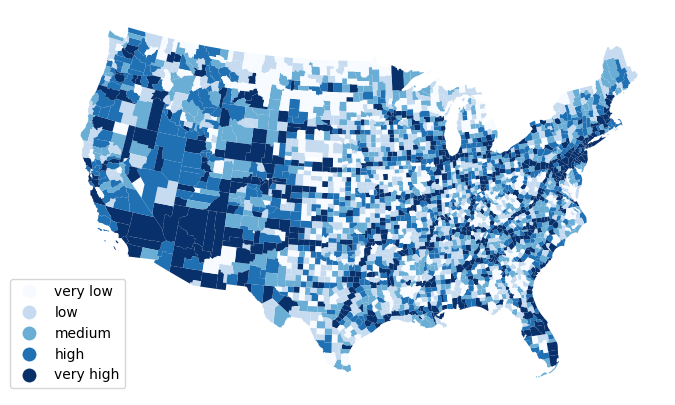

In [106]:
plot_choropleth(
    'pci_cat',
    'Blues',
    'Grouped Aggregated Place Connectivity Index (2019), by County',
    'Source: 2018 county boundaries from US Census Bureau; 2019 PCI by Li et al.',
)

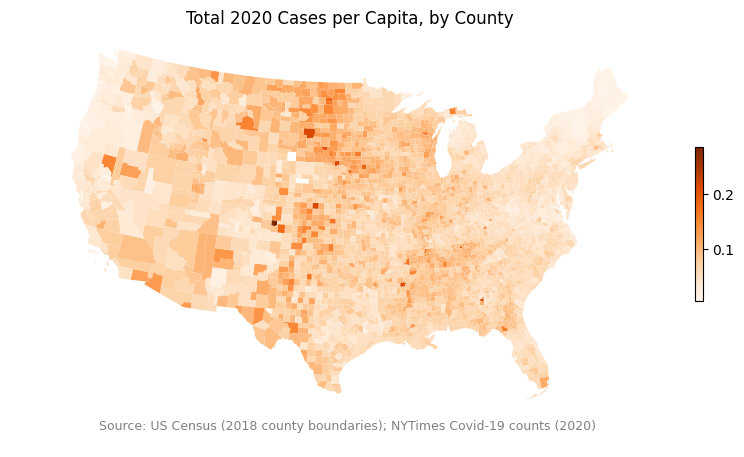

In [30]:
plot_choropleth(
    'year_cp',
    'Oranges',
    'Total 2020 Cases per Capita, by County',
    'Source: US Census (2018 county boundaries); NYTimes Covid-19 counts (2020)',
)

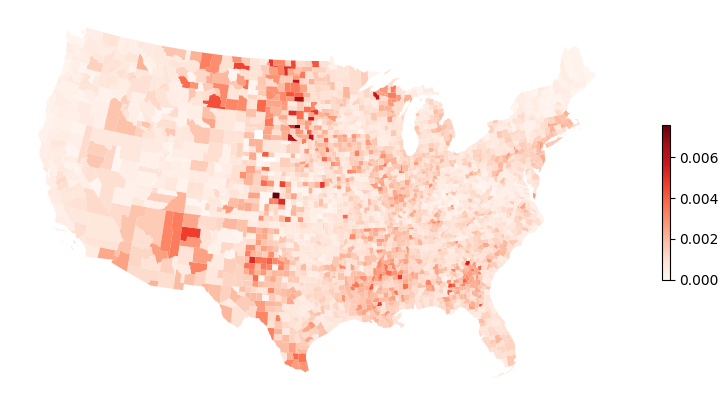

In [109]:
plot_choropleth(
    'year_dp',
    'Reds',
    'Covid-19 Deaths per Capita (2020), by County',
    'Source: US Census (2018 county boundaries); NYTimes Covid-19 case/death counts (2020)',
)

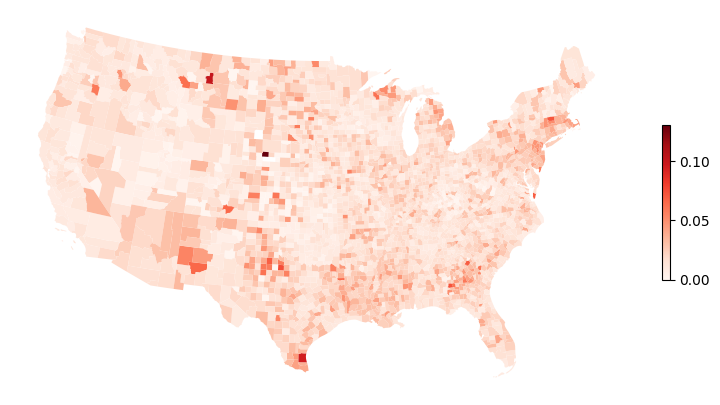

In [110]:
plot_choropleth(
    'year_dc',
    'Reds',
    'Deaths per Positive Covid-19 Case (2020), by County',
    'Source: US Census (2018 county boundaries); NYTimes Covid-19 case/death counts (2020)',
)

In [33]:
months = [ '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [59]:
def plotdeathratio_bygroup(df):
    
    fig, axes = plt.subplots(
        nrows=1, ncols=len(df['pci_cat'].unique()), figsize=(15, 5)
    )

    grouped = (
        combined.groupby('pci_cat')[[f'deaths_{m}' for m in months]].sum().div(
            combined.groupby('pci_cat')[[f'cases_{m}' for m in months]].sum().values
        )
    )

    grouped.columns = [f'drate_{m}' for m in months]

    i = 0
    for group in grouped.index.categories:
        
        axes[i].plot(
            months,
            grouped.loc[group][['drate_' + m for m in months]].values,
            label=group,
            color='red'
        )
        axes[i].set_xlabel('Month')
        axes[i].set_ylabel('Deaths / Cases')
        axes[i].set_title(group.title())
        axes[i].set_ylim(0.005, 0.06)
        i += 1

    plt.tight_layout()
    plt.show()

/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/3399468385.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby('pci_cat')[[f'deaths_{m}' for m in months]].sum().div(
/var/folders/w6/kmxyhb092_3gsgy99f9_t01r0000gn/T/ipykernel_1386/3399468385.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined.groupby('pci_cat')[[f'cases_{m}' for m in months]].sum().values


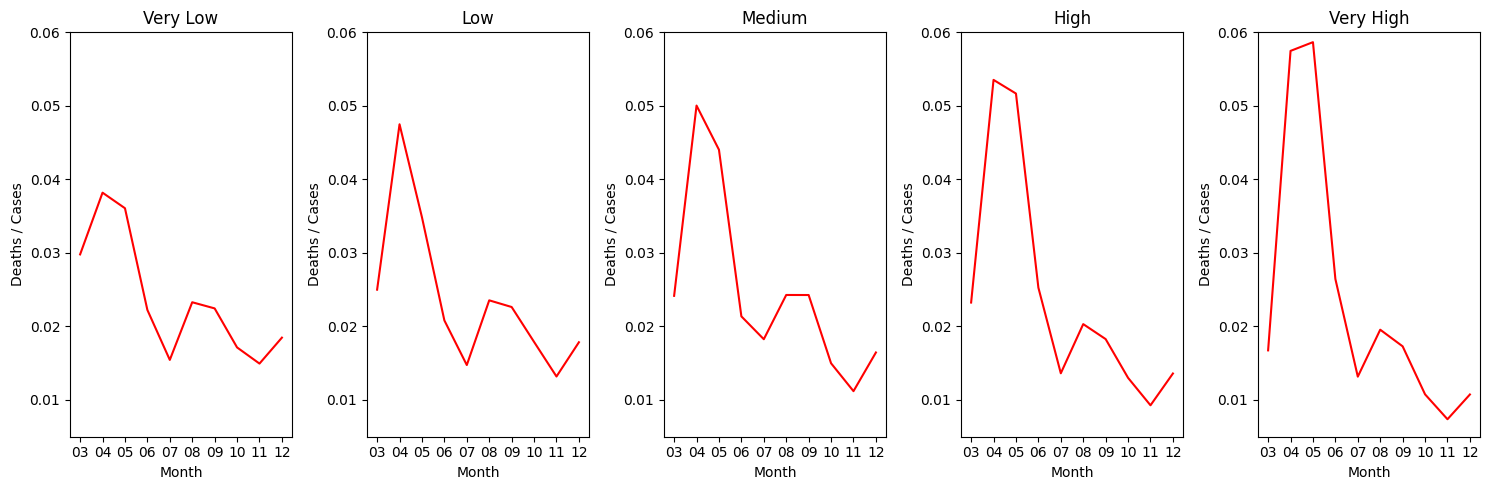

In [60]:
plotdeathratio_bygroup(combined)

### Run ANOVA to test if differences in death_rate means are statistically significant between the PCI groups

In [94]:
anovas = []

for m in months:
    
    samples = [
        combined.query('pci_cat == "very low"')[f'dc_{m}'].dropna().tolist(),
        combined.query('pci_cat == "low"')[f'dc_{m}'].dropna().tolist(),
        combined.query('pci_cat == "medium"')[f'dc_{m}'].dropna().tolist(),
        combined.query('pci_cat == "high"')[f'dc_{m}'].dropna().tolist(),
        combined.query('pci_cat == "very high"')[f'dc_{m}'].dropna().tolist()
    ]

    test = stats.f_oneway(*samples)
    print(m, '-- PASSED' if test.pvalue < 0.05 else 'NOT PASSED')
    print(test)
    print('***')

    anovas.append(round(test.pvalue, 3))

03 NOT PASSED
F_onewayResult(statistic=2.067554003617511, pvalue=0.08244362710196974)
***
04 -- PASSED
F_onewayResult(statistic=3.7557007140444414, pvalue=0.004719295003474352)
***
05 NOT PASSED
F_onewayResult(statistic=1.6416049296765796, pvalue=0.1609513103934803)
***
06 NOT PASSED
F_onewayResult(statistic=1.0461572681169204, pvalue=0.38178582287288454)
***
07 -- PASSED
F_onewayResult(statistic=3.003927076874649, pvalue=0.017378673019918384)
***
08 NOT PASSED
F_onewayResult(statistic=0.25205617918743733, pvalue=0.908521716223635)
***
09 NOT PASSED
F_onewayResult(statistic=1.2362026834717776, pvalue=0.2932524979076293)
***
10 -- PASSED
F_onewayResult(statistic=7.630500122679995, pvalue=4.091172113477872e-06)
***
11 -- PASSED
F_onewayResult(statistic=26.13853003229885, pvalue=2.4199561740739323e-21)
***
12 -- PASSED
F_onewayResult(statistic=13.574112782815499, pvalue=5.6763711427788916e-11)
***


In [97]:
anovas

[0.082, 0.005, 0.161, 0.382, 0.017, 0.909, 0.293, 0.0, 0.0, 0.0]

### Run a t-test on PCI vs monthly death/cases
- This is statistically very significant at p_val $\approx$ 0

In [37]:
ttest_data = combined.dropna()

for m in months:
    
    t_stat, p_val = stats.ttest_ind(ttest_data.pci, ttest_data[f'dc_{m}'], equal_var=False)
    print("Month", m, "PASSED" if p_val < 0.05 else "NOT PASSED", "t-value: ", t_stat, "p-value: ", p_val)

Month 03 PASSED t-value:  103.08659745304459 p-value:  0.0
Month 04 PASSED t-value:  103.08614517827948 p-value:  0.0
Month 05 PASSED t-value:  103.08614773719145 p-value:  0.0
Month 06 PASSED t-value:  103.08636500393088 p-value:  0.0
Month 07 PASSED t-value:  103.08658400757551 p-value:  0.0
Month 08 PASSED t-value:  103.08645289836105 p-value:  0.0
Month 09 PASSED t-value:  103.08638763767624 p-value:  0.0
Month 10 PASSED t-value:  103.08655756143486 p-value:  0.0
Month 11 PASSED t-value:  103.0865940973331 p-value:  0.0
Month 12 PASSED t-value:  103.08651078551422 p-value:  0.0


In [115]:
# For the whole year:

t_stat, p_val = stats.ttest_ind(ttest_data.pci, ttest_data[f'year_dc'], equal_var=False)
print("Month", m, "PASSED" if p_val < 0.05 else "NOT PASSED", "t-value: ", t_stat, "p-value: ", p_val)

Month 2020-12 PASSED t-value:  103.08653459822496 p-value:  0.0


## PCI vs death rate correlation, by month

In [113]:
months = []
corrs = []

for i in range(3, 13):
    
    m = f'2020-{0 if i < 10 else ""}{i}'
    months.append(m[-2:])

    monthly = (
        covid20
        #.query(f'month == "{m}"') # TODO: comment this to run it for the whole year (not individual month)
        .groupby('fips')
        [['cases', 'deaths']]
        .sum()
        .assign(drate=lambda x: (x.deaths / x.cases).fillna(0))
        .reset_index()
        .merge(pci, how='left', on='fips')
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

    corr = round(monthly.drate.corr(monthly.pci), 10)
    corrs.append(corr)

    print('Month: ', m)
    print('Corr: ', corr)
    print('***')

Month:  2020-03
Corr:  -0.0998551529
***
Month:  2020-04
Corr:  -0.0998551529
***
Month:  2020-05
Corr:  -0.0998551529
***
Month:  2020-06
Corr:  -0.0998551529
***
Month:  2020-07
Corr:  -0.0998551529
***
Month:  2020-08
Corr:  -0.0998551529
***
Month:  2020-09
Corr:  -0.0998551529
***
Month:  2020-10
Corr:  -0.0998551529
***
Month:  2020-11
Corr:  -0.0998551529
***
Month:  2020-12
Corr:  -0.0998551529
***


Text(0.5, 1.0, 'PCI vs Death Rate Correlation Coefficient, by month')

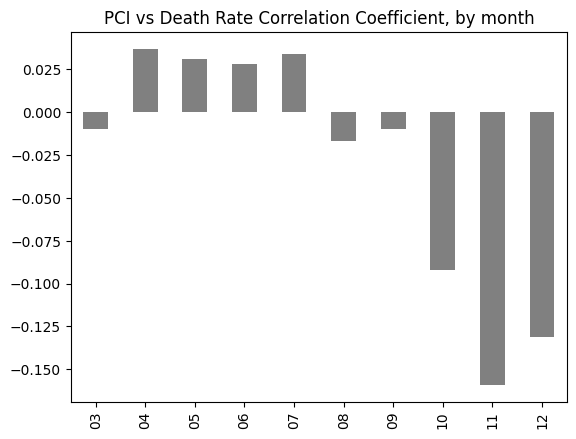

In [39]:
fig = pd.Series(index=months, data=corrs).plot.bar(color='gray')
fig.set_title('PCI vs Death Rate Correlation Coefficient, by month')

## GWR

In [40]:
gwr_data = (
    combined
    .assign(
        point=lambda gdf_: gdf_.geometry.representative_point(),

        # New deaths by month, per capita
        dp03=lambda gdf_: gdf_.deaths_03 / gdf_.pop19,
        dp04=lambda gdf_: gdf_.deaths_04 / gdf_.pop19,
        dp05=lambda gdf_: gdf_.deaths_05 / gdf_.pop19,
        dp06=lambda gdf_: gdf_.deaths_06 / gdf_.pop19,
        dp07=lambda gdf_: gdf_.deaths_07 / gdf_.pop19,
        dp08=lambda gdf_: gdf_.deaths_08 / gdf_.pop19,
        dp09=lambda gdf_: gdf_.deaths_09 / gdf_.pop19,
        dp10=lambda gdf_: gdf_.deaths_10 / gdf_.pop19,
        dp11=lambda gdf_: gdf_.deaths_11 / gdf_.pop19,
        dp12=lambda gdf_: gdf_.deaths_12 / gdf_.pop19,

        # New cases by month, per capita
        cp03=lambda gdf_: gdf_.cases_03 / gdf_.pop19,
        cp04=lambda gdf_: gdf_.cases_04 / gdf_.pop19,
        cp05=lambda gdf_: gdf_.cases_05 / gdf_.pop19,
        cp06=lambda gdf_: gdf_.cases_06 / gdf_.pop19,
        cp07=lambda gdf_: gdf_.cases_07 / gdf_.pop19,
        cp08=lambda gdf_: gdf_.cases_08 / gdf_.pop19,
        cp09=lambda gdf_: gdf_.cases_09 / gdf_.pop19,
        cp10=lambda gdf_: gdf_.cases_10 / gdf_.pop19,
        cp11=lambda gdf_: gdf_.cases_11 / gdf_.pop19,
        cp12=lambda gdf_: gdf_.cases_12 / gdf_.pop19,
    )
    .filter([
        'fips', 'pci', 'point',
        'year_dp', 'year_cp', 'year_dc', 'pop19',
        'deaths_03', 'deaths_04', 'deaths_05', 'cases_03', 'cases_04', 'cases_05',
        'deaths_10', 'deaths_11', 'deaths_12', 'cases_10', 'cases_11', 'cases_12',
        'dc_03', 'dc_04', 'dc_05', 'dc_06', 'dc_07', 'dc_08', 'dc_09', 'dc_10', 'dc_11', 'dc_12',
        'dp03', 'dp04', 'dp05', 'dp06', 'dp07', 'dp08', 'dp09', 'dp10', 'dp11', 'dp12',
        'cp03', 'cp04', 'cp05', 'cp06', 'cp07', 'cp08', 'cp09', 'cp10', 'cp11', 'cp12',
        'geometry'
    ])
    .dropna()
)

In [41]:
%%time

_coords = list(zip(gwr_data.point.x, gwr_data.point.y))
_pci = np.log10(gwr_data.pci.values.reshape(-1, 1))

# Death per pop (by month) - reshape
_dp03 = gwr_data.dp03.values.reshape(-1, 1)
_dp04 = gwr_data.dp04.values.reshape(-1, 1)
_dp05 = gwr_data.dp05.values.reshape(-1, 1)
_dp06 = gwr_data.dp06.values.reshape(-1, 1)
_dp07 = gwr_data.dp07.values.reshape(-1, 1)
_dp08 = gwr_data.dp08.values.reshape(-1, 1)
_dp09 = gwr_data.dp09.values.reshape(-1, 1)
_dp10 = gwr_data.dp10.values.reshape(-1, 1)
_dp11 = gwr_data.dp11.values.reshape(-1, 1)
_dp12 = gwr_data.dp12.values.reshape(-1, 1)

# Cases per pop (by month) reshape
_cp03 = gwr_data.cp03.values.reshape(-1, 1)
_cp04 = gwr_data.cp04.values.reshape(-1, 1)
_cp05 = gwr_data.cp05.values.reshape(-1, 1)
_cp06 = gwr_data.cp06.values.reshape(-1, 1)
_cp07 = gwr_data.cp07.values.reshape(-1, 1)
_cp08 = gwr_data.cp08.values.reshape(-1, 1)
_cp09 = gwr_data.cp09.values.reshape(-1, 1)
_cp10 = gwr_data.cp10.values.reshape(-1, 1)
_cp11 = gwr_data.cp11.values.reshape(-1, 1)
_cp12 = gwr_data.cp12.values.reshape(-1, 1)

# Deaths per case (by month) reshape
_dc03 = gwr_data.dc_03.values.reshape(-1, 1)
_dc04 = gwr_data.dc_04.values.reshape(-1, 1)
_dc05 = gwr_data.dc_05.values.reshape(-1, 1)
_dc06 = gwr_data.dc_06.values.reshape(-1, 1)
_dc07 = gwr_data.dc_07.values.reshape(-1, 1)
_dc08 = gwr_data.dc_08.values.reshape(-1, 1)
_dc09 = gwr_data.dc_09.values.reshape(-1, 1)
_dc10 = gwr_data.dc_10.values.reshape(-1, 1)
_dc11 = gwr_data.dc_11.values.reshape(-1, 1)
_dc12 = gwr_data.dc_12.values.reshape(-1, 1)

# Yearly
_cpY = gwr_data.year_cp.values.reshape(-1, 1)
_dpY = gwr_data.year_dp.values.reshape(-1, 1)
_dcY = gwr_data.year_dc.values.reshape(-1, 1)

# Last 3 months
_dc10_12 = (
    (gwr_data.deaths_10 + gwr_data.deaths_11 + gwr_data.deaths_12)
        / (gwr_data.cases_10 + gwr_data.cases_11 + gwr_data.cases_12).values
    ).values.reshape(-1, 1)

_dp10_12 = (
    (gwr_data.deaths_10 + gwr_data.deaths_11 + gwr_data.deaths_12)
        / (gwr_data.pop19 + gwr_data.pop19 + gwr_data.pop19).values
        * 1000
    ).values.reshape(-1, 1)

# First 3 months
_dc03_05 = (
    (gwr_data.deaths_03 + gwr_data.deaths_04 + gwr_data.deaths_05)
        / (gwr_data.cases_03 + gwr_data.cases_04 + gwr_data.cases_05).values
    ).values.reshape(-1, 1)
_dc03_05 = np.nan_to_num(_dc03_05)

_dp03_05 = (
    (gwr_data.deaths_03 + gwr_data.deaths_04 + gwr_data.deaths_05)
        / (gwr_data.pop19 + gwr_data.pop19 + gwr_data.pop19).values
        * 1000
    ).values.reshape(-1, 1)

def get_local_r2(d):
    
    gwr_selector = Sel_BW(_coords, d, _pci)
    gwr_bw = gwr_selector.search()
    
    gwr_results = GWR(_coords, d, _pci, gwr_bw).fit()
    
    return (
        gwr_results.R2,
        gwr_results.localR2,
        [x[1] for x in gwr_results.params] # betas
    )

CPU times: user 8.66 ms, sys: 814 µs, total: 9.48 ms
Wall time: 2.68 ms


In [42]:
%%time

# YEARLY
global_dp_r2_y, gwr_data['local_dp_r2_y'], gwr_data['local_dp_beta_y'] = get_local_r2(_dpY)
global_cp_r2_y, gwr_data['local_cp_r2_y'], gwr_data['local_cp_beta_y'] = get_local_r2(_cpY)
global_dc_r2_y, gwr_data['local_dc_r2_y'], gwr_data['local_dc_beta_y']= get_local_r2(_dcY)

print('global deaths/pop: ', global_dp_r2_y)
print('global cases/pop: ', global_cp_r2_y)
print('global deaths/case: ', global_dc_r2_y)

global deaths/pop:  0.41591091931378155
global cases/pop:  0.6292585353238291
global deaths/case:  0.34891828596232766
CPU times: user 5.27 s, sys: 922 ms, total: 6.2 s
Wall time: 9.59 s


In [43]:
%%time

# LAST 3 MONTHS
global_dp_r2_10_12, gwr_data['local_dp_r2_10_12'], gwr_data['local_dp_beta_10_12'] = get_local_r2(_dp10_12)
#global_cp_r2_y, gwr_data['local_cp_r2_10_12'], gwr_data['local_cp_beta_10_12'] = get_local_r2(_cpY)
global_dc_r2_10_12, gwr_data['local_dc_r2_10_12'], gwr_data['local_dc_beta_10_12']= get_local_r2(_dc10_12)

# FIRST 3 MONTHS
global_dp_r2_03_05, gwr_data['local_dp_r2_03_05'], gwr_data['local_dp_beta_03_05'] = get_local_r2(_dp03_05)
#global_cp_r2_y, gwr_data['local_cp_r2_10_12'], gwr_data['local_cp_beta_10_12'] = get_local_r2(_cpY)
global_dc_r2_03_05, gwr_data['local_dc_r2_03_05'], gwr_data['local_dc_beta_03_05']= get_local_r2(_dc03_05)

CPU times: user 6.37 s, sys: 1.09 s, total: 7.46 s
Wall time: 9.11 s


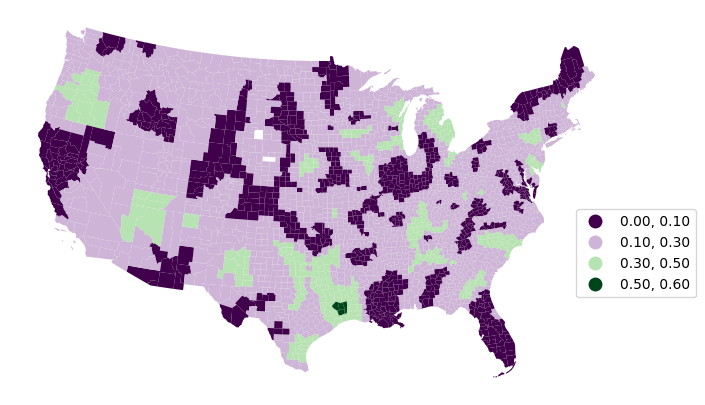

In [127]:
COLUMN = 'local_dc_r2_y'
timespan = ''#'Mar-May 2020'

fig, ax = plt.subplots(figsize=(10, 5))

gwr_data.assign(zzz=lambda df_: df_[COLUMN].clip(lower=0)).plot( # TODO: remove clip for Betas! but clip lower=0 for R2
    column='zzz',
    #cmap=ListedColormap(['#555', '#aaa']), # for Beta
    cmap='PRGn',
    linewidth=0.01,
    legend=True,
    legend_kwds={'bbox_to_anchor':(1.13, 0.5), 'loc': 'upper right'},
    ax=ax,
    scheme='user_defined',
    #classification_kwds={ 'bins': [0] } # for Beta
    classification_kwds={ 'bins': [ 0.1, 0.3, 0.5, 0.6] }
)

# Uncomment below for Beta:
#ax.set_title(f'GWR Beta Coefficient between PCI\nAnd Covid-19 Deaths per Case, {timespan}', fontsize=12)

# Uncomment below for R2:
#ax.set_title(f'GWR R2 between PCI\nAnd Covid-19 Deaths per Case, {timespan}', fontsize=12)

ax.axis('off')

"""
plt.annotate(
    '\n'.join([
        #'Note: Coefficients represent how', # THIS TEXT IS FOR BETA
        #'much PCI impact Covid-19 deaths ',
        #'per positive case. Positive ',
        #'coefficients represent positive',
        #'relationship, and vice-versa.'

        'Note: Purples represent weaker linear', # THIS TEXT IS FOR R2
        'relationship between PCI and death/case ratio,',
        'greens represent stronger relationship'
    ]),
    xy=(65,30),
    xycoords='figure points',
    fontsize=9,
    color='gray',
    ha='left'
)
"""

plt.show()    